In [80]:
## Version futuresales lib required = 0.1.11

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.11
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/


In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, causation_1_percent
from neptune.new.types import File

import seaborn as sns

In [82]:
RUN_NAME = 'FSRES-13'

In [83]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    run=RUN_NAME
)  # your credentials

https://app.neptune.ai/denissimo/FS-Results/e/FSRES-13
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [84]:
task_df = {}

idx = pd.read_csv('../../tmp/idx.csv').rename({'id': 'object_id'}, axis=1)

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv').drop('Unnamed: 0', axis=1)
task_df['dynamic'] = from_pickle('../../tmp/id_sales_test.pkl')

In [85]:
run['dump/residuals'].download()
report = from_pickle('./residuals.pkl')
report['object_id'] = task_df['dynamic'].index
report['residuals'] = report['predicted'] - report['valid_target']

In [86]:
report

,valid_target,residuals,predicted,object_id
0,0.0,0.013704,0.013704,54
1,0.0,0.019300,0.019300,114
2,0.0,0.008251,0.008251,174
3,0.0,0.013704,0.013704,234
4,0.0,0.018937,0.018937,294
...,...,...,...,...
422572,0.0,0.001601,0.001601,1330036
422573,0.0,0.004356,0.004356,1330090
422574,0.0,0.001671,0.001671,1330142
422575,0.0,0.004356,0.004356,1330150


In [87]:
report = report.merge(idx, on='object_id', how='left')

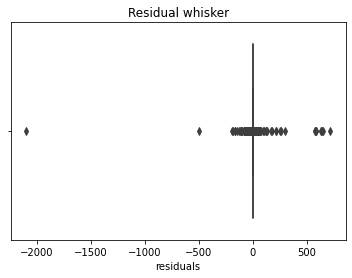

In [88]:
run['analysis/residuals/plots/whisker'].upload(File.as_image(sns.boxplot(data=report, x='residuals').set_title('Residual whisker').figure))

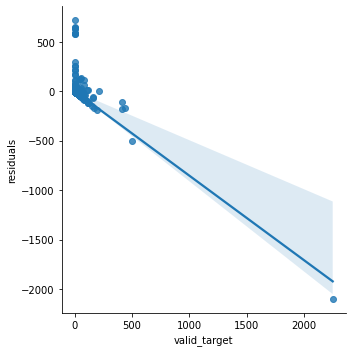

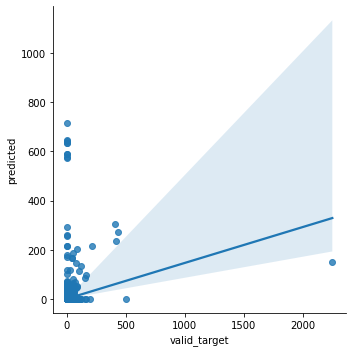

In [89]:
run['analysis/residuals/plots/dependecies'] = {
    'target_residual': File.as_image(sns.lmplot(data=report, x='valid_target', y='residuals').figure),
    'target_predicted': File.as_image(sns.lmplot(data=report, x='valid_target', y='predicted').figure),
}

In [90]:
stable_residual_interval = report.reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])

In [91]:
giant_test, percent_str =  causation_1_percent(stable_residual_interval)

0.1% of objects cause 0.9884303201501586 of error


In [92]:
giant_test

,id,valid_target,residuals,predicted,object_id,Unnamed: 0,item_name,item_id,item_category_id,shop_name,shop_id,item_category_name,abs_residuals,part
269269,269269,12.0,-11.995644,0.004356,680365,680365,ШАКАЛ (BD),21811,37,"Москва ТРК ""Атриум""",25,Кино - Blu-Ray,11.995644,0.000015
291987,291987,23.0,-12.009875,10.990125,775015,775015,1С:Предприятие 8.3. Практическое пособие разра...,805,54,Цифровой склад 1С-Онлайн,55,Книги - Цифра,12.009875,0.000016
422354,422354,18.0,-12.135927,5.864073,1329113,1329113,Прием денежных средств для 1С-Онлайн,17717,79,"Уфа ТЦ ""Семья"" 2",53,Служебные,12.135927,0.000016
122968,122968,13.0,-12.151590,0.848410,351091,351091,IRON MAIDEN The Book Of Souls 2CD,3917,55,"Москва ТЦ ""Семеновский""",31,Музыка - CD локального производства,12.151590,0.000016
342103,342103,13.0,-12.151590,0.848410,1066547,1066547,Меч и Магия. Герои VII. Эксклюзивное издание [...,15069,28,"Сургут ТРЦ ""Сити Молл""",47,Игры PC - Дополнительные издания,12.151590,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419949,419949,0.0,634.942727,634.942727,1317055,1317055,"Билет ""ИгроМир 2015"" - 4 октября 2015 УПР [Циф...",9255,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),634.942727,0.043381
419943,419943,0.0,641.050000,641.050000,1316755,1316755,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) У...",9245,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),641.050000,0.044219
419950,419950,0.0,646.252727,646.252727,1317072,1317072,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [...",9244,80,Интернет-магазин ЧС,12,Служебные - Билеты,646.252727,0.044940
419946,419946,0.0,717.360000,717.360000,1316935,1316935,"Билет ""ИгроМир 2015"" - 3 октября 2015 УПР [Циф...",9251,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),717.360000,0.055373


In [93]:
run['analysis/residuals/top_worst/magic_string'] = percent_str
run['analysis/residuals/top_worst/raw_giants'].upload(File.as_pickle(giant_test))


serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts().reset_index().rename({'id': 'appearence', 'index': 'id'}, axis=1)

In [94]:
top_50 = (giant_test.sort_values('part').reset_index()
    .groupby([
        'object_id', 'shop_id', 'item_id', 'shop_name', 'item_name'])
    .agg({
        'predicted': [np.mean],
        'valid_target': [np.mean], 
        'part': [np.mean], 
        'abs_residuals': [np.mean, lambda x: np.mean(x)**2]})
    .sort_values(('part', 'mean'))
    .tail(50)
    )
run['analysis/residuals/top_worst/top_50_objects'].upload(File.as_html(top_50))

In [95]:
top_15_shops = (giant_test.sort_values('part')
    .groupby([
        'shop_id', 'shop_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_shops'].upload(File.as_html(top_15_shops))

In [96]:
top_15_items= (giant_test.sort_values('part')
    .groupby([
        'item_id', 'item_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_items'].upload(File.as_html(top_15_items))

In [97]:
top_50.reset_index().set_index('object_id')

shop_id item_id                              shop_name  \
                                                                   
object_id                                                          
1065271        31   10201                Москва ТЦ "Семеновский"   
1326920        20   14956                    Москва "Распродажа"   
1095849         9   11526                      Выездная Торговля   
506971         31    2047                Москва ТЦ "Семеновский"   
1076142        42    7224                 СПб ТК "Невский Центр"   
1244541        21   20949                 Москва МТРЦ "Афи Молл"   
1317136        16    9246                       Коломна ТЦ "Рио"   
1285869         9   15047                      Выездная Торговля   
1287860        20   16843                    Москва "Распродажа"   
1065246         6   10201             Воронеж (Плехановская, 13)   
1321209         9   13246                      Выездная Торговля   
528429          9    7018                      Выездная Торговля   
519969          9    4719                      Выездная Торговля   
1076125        25    7224                    Москва ТРК "Атриум"   
1266295        55    7966               Цифровой склад 1С-Онлайн   
1076905        25   10202                    Москва ТРК "Атриум"   
1317148        28    9246        Москва ТЦ "МЕГА Теплый Стан" II   
525789          9    6503                      Выездная Торговля   
1244551        31   20949                Москва ТЦ "Семеновский"   
1076922        42   10202                 СПб ТК "Невский Центр"   
1071266        26    3445            Москва ТЦ "Ареал" (Беляево)   
1321220        20   13246                    Москва "Распродажа"   
1244559        39   20949  РостовНаДону ТРК "Мегацентр Горизонт"   
1225831        31    5675                Москва ТЦ "Семеновский"   
1266655        55   13098               Цифровой склад 1С-Онлайн   
1287849         9   16843                      Выездная Торговля   
1234231        31   14839                Москва ТЦ "Семеновский"   
1065282        42   10201                 СПб ТК "Невский Центр"   
1065265        25   10201                    Москва ТРК "Атриум"   
1244545        25   20949                    Москва ТРК "Атриум"   
1317262        22    9250                     Москва Магазин С21   
1317151        31    9246                Москва ТЦ "Семеновский"   
1244562        42   20949                 СПб ТК "Невский Центр"   
900009          9    4201                      Выездная Торговля   
1317268        28    9250        Москва ТЦ "МЕГА Теплый Стан" II   
1317265        25    9250                    Москва ТРК "Атриум"   
1317145        25    9246                    Москва ТРК "Атриум"   
1317271        31    9250                Москва ТЦ "Семеновский"   
1317385        25    9254                    Москва ТРК "Атриум"   
1244532        12   20949                    Интернет-магазин ЧС   
1316995        55    9253               Цифровой склад 1С-Онлайн   
1317312        12    9252                    Интернет-магазин ЧС   
1316875        55    9249               Цифровой склад 1С-Онлайн   
1317192        12    9248                    Интернет-магазин ЧС   
1316815        55    9247               Цифровой склад 1С-Онлайн   
1317055        55    9255               Цифровой склад 1С-Онлайн   
1316755        55    9245               Цифровой склад 1С-Онлайн   
1317072        12    9244                    Интернет-магазин ЧС   
1316935        55    9251               Цифровой склад 1С-Онлайн   
1317972        12   11373                    Интернет-магазин ЧС   

                                                   item_name   predicted  \
                                                                    mean   
object_id                                                                  
1065271    Ведьмак 3: Дикая Охота - Дополнение "Каменные ...    1.105527   
1326920                       Манга Без игры жизни нет Том 1    1.105527   
1095849                  

{1316935, 1317072, 1316755, 1317972, 1317055}
{1317312, 1316995, 1317192, 1316875, 1316815}
{1317385, 1317265, 1244532, 1317271, 1317145}
{900009, 1317262, 1244562, 1317268, 1317151}
{1244545, 1065282, 1287849, 1065265, 1234231}
{1071266, 1321220, 1225831, 1244559, 1266655}
{1244551, 1076905, 1076922, 1317148, 525789}
{519969, 528429, 1266295, 1321209, 1076125}
{1285869, 1317136, 1287860, 1244541, 1065246}
{1326920, 1095849, 1076142, 1065271, 506971}


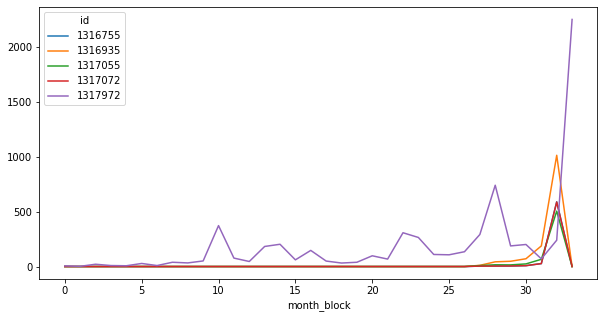

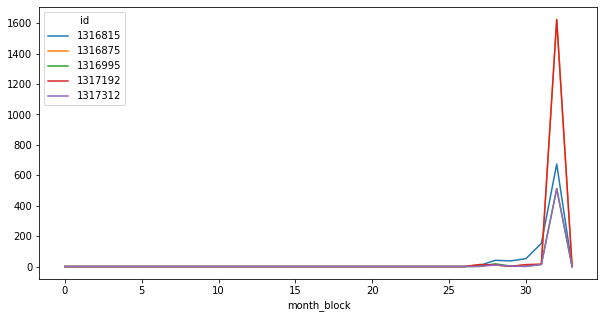

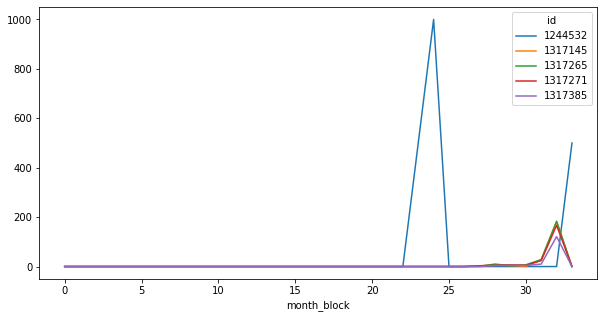

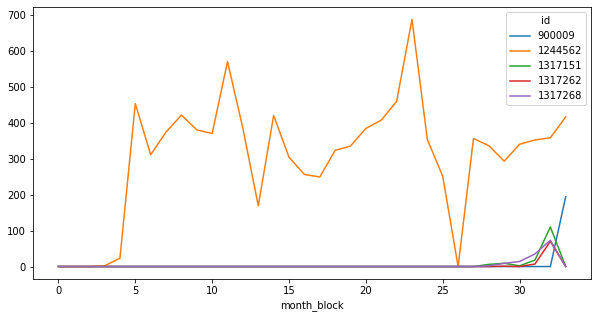

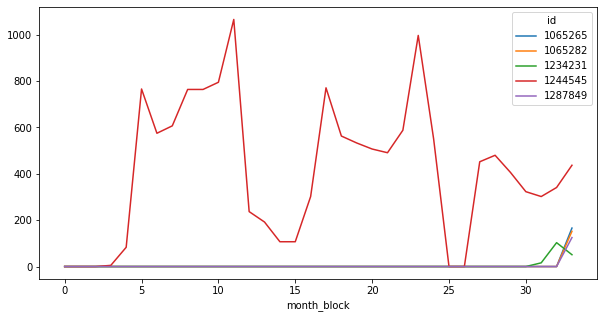

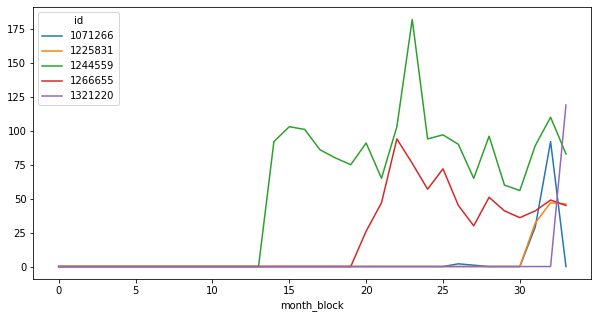

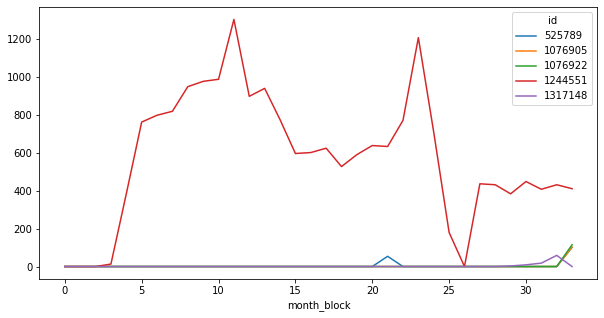

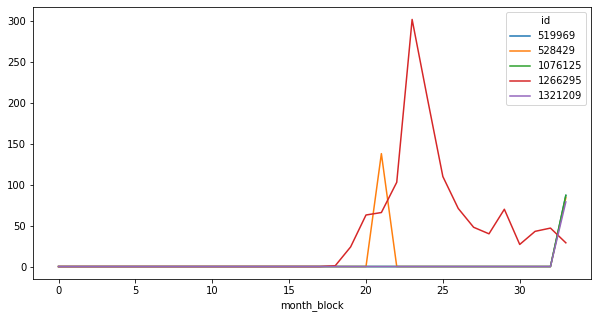

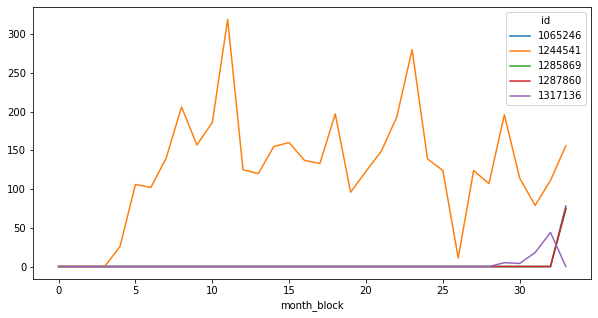

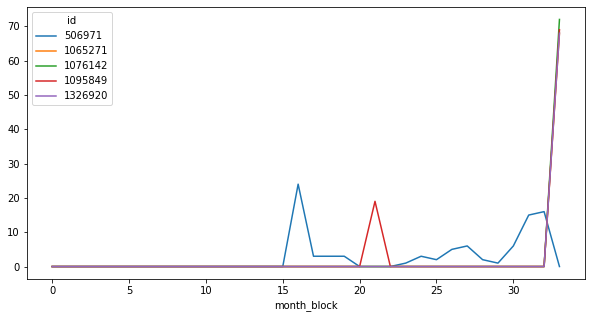

In [98]:
for i in range(0, 10):
    id_slice = top_50.reset_index().set_index('object_id').index.to_list()[-5 - 5*i: -5 - 5*(i - 1)] if i != 0 else top_50.reset_index().set_index('object_id').index.to_list()[-5: None]
    print(set(id_slice) & set(task_df['dynamic'].index))
    fig = task_df['dynamic'][task_df['dynamic'].index.isin(id_slice)].transpose().plot(figsize=(10, 5)).figure
    run[f'analysis/residuals/plots/top_{5*i}-{5*(i + 1)}_items'].upload(File.as_image(fig))

In [99]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 33 operations to synchronize with Neptune. Do not kill this process.


All 33 operations synced, thanks for waiting!
